In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import csv
import json
import pandas as pd
import math
import statistics

In [32]:
stats = {}

## Measured job load

In [33]:
csvfile = open('../cirrus-cpu-simple-rigid/data/raw-job-data/raw_job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
measured_job_l = []
maxtime = 0
for row in csvreader:
    if int(row['End Time']) > maxtime:
        maxtime = int(row['End Time'])
    if row['Nodes'] is None:
        print(row)
    measured_job_l.append(row)

measured_job_df = pd.DataFrame(measured_job_l)
measured_job_df['Start Time'] = measured_job_df['Start Time'].astype(int)
measured_job_df['Wait Time'] = measured_job_df['Wait Time'].astype(int)
measured_job_df['Nodes'] = measured_job_df['Nodes'].astype(int)
measured_job_df['Makespan'] = measured_job_df['Makespan'].astype(int)
measured_job_df['Total Time'] = measured_job_df['Wait Time'] + measured_job_df['Makespan']
measured_job_df['Coreh'] = measured_job_df['Makespan'] * measured_job_df['Nodes']

print(measured_job_df)

print(measured_job_df['Coreh'].sum())

          ID   Type Submit Time  Start Time End Time  Wait Time  Makespan  \
0          0  Rigid           0        2984     4407       2984      1423   
1          1  Rigid         715        3839     4287       3124       448   
2          2  Rigid         715        3839     4311       3124       472   
3          3  Rigid         715        4288     4708       3573       420   
4          4  Rigid        1698        4408     5886       2710      1478   
...      ...    ...         ...         ...      ...        ...       ...   
11630  11630  Rigid       23977       24094    24923        117       829   
11631  11631  Rigid       23980       23982    24011          2        29   
11632  11632  Rigid       23983       24792    25818        809      1026   
11633  11633  Rigid       23983       24804    25757        821       953   
11634  11634  Rigid       23983       24804    24894        821        90   

      Turnaround Time     Status  Nodes  Total Time    Coreh  
0           

In [34]:
measured_load_a = np.zeros(maxtime+1, dtype=int)
totuse = 0
for job in measured_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = int(job['Start Time'])
    iend = int(job['End Time'])
    nodes = int(job['Nodes'])
    totuse = totuse + int(job['Makespan'])
    temp_a[istart:iend] = nodes
    measured_load_a = measured_load_a + temp_a

print(totuse)

4075948


<Figure size 640x480 with 0 Axes>

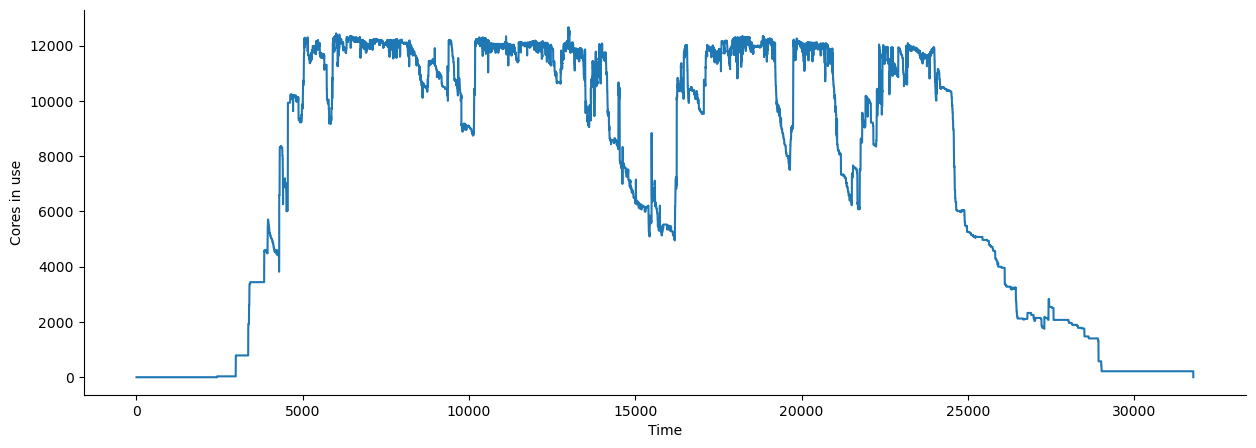

In [35]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.plot(measured_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("measured_load.png")

In [36]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Measured'
stats[type] = {}

stats[type]['nJobStart'] = sum((measured_job_df['Start Time'] >= timeLower) & (measured_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats[type]['nJobStart']}")

stats[type]['minLoad'] = min(measured_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(measured_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(measured_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(measured_load_a[timeLower:timeUpper+1])

usageVal = sum(measured_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal
stats[type]['usageExcluded'] = sum(measured_load_a[0:timeLower]) + sum(measured_load_a[timeUpper:])
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * statsMeasured['usageFraction']}")

measured_slice_df = measured_job_df.loc[(measured_job_df['Start Time'] >= timeLower) & (measured_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = measured_slice_df['Wait Time'].min()
stats[type]['medianWait'] = measured_slice_df['Wait Time'].median()
stats[type]['maxWait'] = measured_slice_df['Wait Time'].max()
stats[type]['meanWait'] = measured_slice_df['Wait Time'].mean()

print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTotJobTime'] = measured_slice_df['Total Time'].min()
stats[type]['medianTotJobTime'] = measured_slice_df['Total Time'].median()
stats[type]['maxTotJobTime'] = measured_slice_df['Total Time'].max()
stats[type]['meanTotJobTime'] = measured_slice_df['Total Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTotJobTime']}")
print(f" median = {stats[type]['medianTotJobTime']}")
print(f"    max = {stats[type]['maxTotJobTime']}")
print(f"   mean = {stats[type]['meanTotJobTime']}")



Job data:
    nJobs = 10749
Load statistics:
    min = 4949
 median = 11698
    max = 12664
   mean = 10677


NameError: name 'statsMeasured' is not defined

## Simulated job load (rigid)

In [37]:
csvfile = open('../cirrus-cpu-simple-rigid/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
rigid_job_l = []
for row in csvreader:
    rigid_job_l.append(row)




In [38]:
jsonfile = open('../cirrus-cpu-simple-rigid/data/input/2024_Q1_CPU-jobs.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
for job in jobs_d['jobs']:
    rigid_job_l[i]['Nodes'] = int(job['num_nodes'])
    rigid_job_l[i]['JobID'] = job['arguments']['jobid']
    totuse = totuse + float(rigid_job_l[i]['Makespan']) * rigid_job_l[i]['Nodes']
    if float(rigid_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(rigid_job_l[i]['End Time']))
    i += 1

rigid_job_df = pd.DataFrame(rigid_job_l)
rigid_job_df['Start Time'] = rigid_job_df['Start Time'].astype(int)
rigid_job_df['Wait Time'] = rigid_job_df['Wait Time'].astype(float)
rigid_job_df['Nodes'] = rigid_job_df['Nodes'].astype(int)
rigid_job_df['Makespan'] = rigid_job_df['Makespan'].astype(int)
rigid_job_df['Total Time'] = rigid_job_df['Wait Time'] + rigid_job_df['Makespan']
rigid_job_df['Coreh'] = rigid_job_df['Makespan'] * rigid_job_df['Nodes']

print(rigid_job_df)

print(rigid_job_df['Coreh'].sum())

          ID   Type Submit Time  Start Time End Time  Wait Time  Makespan  \
0          0  rigid           0           0     1423        0.0      1423   
1          1  rigid         715         715     1163        0.0       448   
2          2  rigid         715         715     1187        0.0       472   
3          3  rigid         715         715     1135        0.0       420   
4          4  rigid        1698        1698     3176        0.0      1478   
...      ...    ...         ...         ...      ...        ...       ...   
11630  11630  rigid       23977       24071    24900       94.0       829   
11631  11631  rigid       23980       24140    24169      160.0        29   
11632  11632  rigid       23983       24141    25167      158.0      1026   
11633  11633  rigid       23983       24141    25094      158.0       953   
11634  11634  rigid       23983       24141    24231      158.0        90   

      Turnaround Time     Status  Nodes      JobID  Total Time    Coreh  
0

In [39]:
rigid_load_a = np.zeros(maxtime+1, dtype=int)

In [40]:
for job in rigid_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    rigid_load_a = rigid_load_a + temp_a

print(rigid_load_a)

[756 756 756 ... 216 216   0]


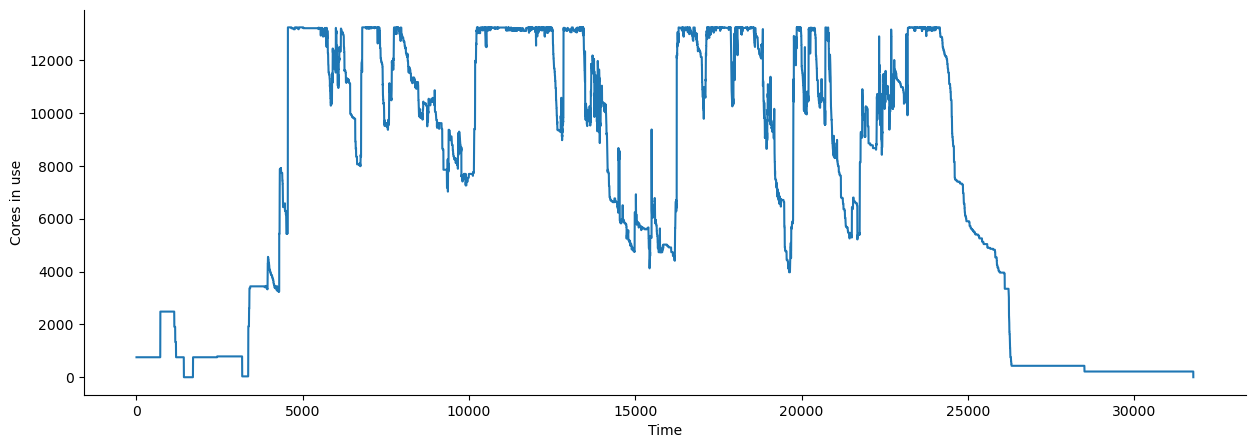

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(rigid_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("simulated_load_rigid.png")

In [42]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Rigid'
stats[type] = {}


stats[type]['nJobStart'] = sum((rigid_job_df['Start Time'] >= timeLower) & (rigid_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats['Measured']['nJobStart']}")

stats[type]['minLoad'] = min(rigid_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(rigid_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(rigid_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(rigid_load_a[timeLower:timeUpper+1])

usageVal = sum(rigid_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal
stats[type]['usageExcluded'] = sum(rigid_load_a[0:timeLower]) + sum(rigid_load_a[timeUpper:])
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * stats[type]['usageFraction']}")

rigid_slice_df = rigid_job_df.loc[(rigid_job_df['Start Time'] >= timeLower) & (rigid_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = rigid_slice_df['Wait Time'].min()
stats[type]['medianWait'] = rigid_slice_df['Wait Time'].median()
stats[type]['maxWait'] = rigid_slice_df['Wait Time'].max()
stats[type]['meanWait'] = rigid_slice_df['Wait Time'].mean()



print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTotJobTime'] = rigid_slice_df['Total Time'].min()
stats[type]['medianTotJobTime'] = rigid_slice_df['Total Time'].median()
stats[type]['maxTotJobTime'] = rigid_slice_df['Total Time'].max()
stats[type]['meanTotJobTime'] = rigid_slice_df['Total Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTotJobTime']}")
print(f" median = {stats[type]['medianTotJobTime']}")
print(f"    max = {stats[type]['maxTotJobTime']}")
print(f"   mean = {stats[type]['meanTotJobTime']}")



Job data:
    nJobs = 10749
Load statistics:
    min = 3974
 median = 11252
    max = 13249
   mean = 10583
 %usage = 79.8930022980408
Wait time statistics:
    min = -1.92813e-10
 median = 48.0
    max = 1336.0
   mean = 160.29503453424945
Total job time statistics:
    min = 0.999999999861757
 median = 213.0
    max = 12619.0
   mean = 495.7196191898404


## Moldable jobs

In [43]:
csvfile = open('../cirrus-cpu-simple-moldable/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
moldable_job_l = []
for row in csvreader:
    moldable_job_l.append(row)


print(moldable_job_l[0])
print(moldable_job_l[-1])


{'ID': '0', 'Type': 'moldable', 'Submit Time': '0', 'Start Time': '0', 'End Time': '711.5', 'Wait Time': '0', 'Makespan': '711.5', 'Turnaround Time': '711.5', 'Status': 'completed'}
{'ID': '11634', 'Type': 'moldable', 'Submit Time': '23983', 'Start Time': '24242.5', 'End Time': '24287.5', 'Wait Time': '259.5', 'Makespan': '45', 'Turnaround Time': '304.5', 'Status': 'completed'}


In [44]:
jsonfile = open('../cirrus-cpu-simple-moldable/data/input/2024_Q1_CPU-jobs_moldable.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
jobid_l = []
for job in jobs_d['jobs']:
    jobid_l.append(job['arguments']['jobid'])
    moldable_job_l[i]['JobID'] = job['arguments']['jobid']
    moldable_job_l[i]['BaseNodes'] = int(job['arguments']['base_nodes'])
    moldable_job_l[i]['MinNodes'] = int(job['num_nodes_min'])
    moldable_job_l[i]['MaxNodes'] = int(job['num_nodes_max'])
    i += 1


In [45]:
nodedata_df = pd.read_csv('../cirrus-cpu-simple-moldable/data/output/node_utilization.csv')
nodedata_df['Count'] = 1
nodedata_df.tail()

,Time,Node,State,Running jobs,Expected jobs,Count
1538754,28988.0,CCPU_11115,free,none,none,1
1538755,28988.0,CCPU_11116,free,none,none,1
1538756,28988.0,CCPU_11117,free,none,none,1
1538757,28988.0,CCPU_11118,free,none,none,1
1538758,28988.0,CCPU_11119,free,none,none,1


In [46]:
# nodecount_grouped = nodedata_df.groupby(by='Running jobs')['Count'].sum()
nodecount_grouped = nodedata_df.loc[nodedata_df['State'] == 'allocated'].groupby(by='Running jobs', sort=False)['Running jobs'].count()

In [47]:

for i, job in enumerate(moldable_job_l):
    cores = nodecount_grouped.iloc[i]
    moldable_job_l[i]['Nodes'] = cores
    totuse = totuse + float(moldable_job_l[i]['Makespan']) * moldable_job_l[i]['Nodes']
    if float(moldable_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(moldable_job_l[i]['End Time']))

moldable_job_df = pd.DataFrame(moldable_job_l)
moldable_job_df['Start Time'] = moldable_job_df['Start Time'].astype(float)
moldable_job_df['Wait Time'] = moldable_job_df['Wait Time'].astype(float)
moldable_job_df['Nodes'] = moldable_job_df['Nodes'].astype(int)
moldable_job_df['Makespan'] = moldable_job_df['Makespan'].astype(float)
moldable_job_df['Total Time'] = moldable_job_df['Wait Time'] + moldable_job_df['Makespan']
moldable_job_df['Coreh'] = moldable_job_df['Makespan'] * moldable_job_df['Nodes']
print(moldable_job_df)

print(moldable_job_df['Coreh'].sum())

          ID      Type Submit Time  Start Time End Time  Wait Time  Makespan  \
0          0  moldable           0         0.0    711.5        0.0     711.5   
1          1  moldable         715       715.0      939        0.0     224.0   
2          2  moldable         715       715.0      951        0.0     236.0   
3          3  moldable         715       715.0      925        0.0     210.0   
4          4  moldable        1698      1698.0     2437        0.0     739.0   
...      ...       ...         ...         ...      ...        ...       ...   
11630  11630  moldable       23977     24238.5    25482      261.5    1243.5   
11631  11631  moldable       23980     24240.0  24254.5      260.0      14.5   
11632  11632  moldable       23983     24242.5  24755.5      259.5     513.0   
11633  11633  moldable       23983     24242.5    24719      259.5     476.5   
11634  11634  moldable       23983     24242.5  24287.5      259.5      45.0   

      Turnaround Time     Status      J

In [48]:
nrigid = len(moldable_job_df.loc[moldable_job_df['Nodes'] == moldable_job_df['BaseNodes']])
nmoldable = len(moldable_job_df.loc[moldable_job_df['Nodes'] != moldable_job_df['BaseNodes']])
nlarger = len(moldable_job_df.loc[moldable_job_df['Nodes'] > moldable_job_df['BaseNodes']])
nsmaller = len(moldable_job_df.loc[moldable_job_df['Nodes'] < moldable_job_df['BaseNodes']])
ntot = len(moldable_job_df)

print(f'Number of jobs at original size = {nrigid}/{ntot} ({100*nrigid/ntot:.2f}%)')
print(f'Number of jobs molded = {nmoldable}/{ntot} ({100*nmoldable/ntot:.2f}%)')
print(f'Number of jobs larger = {nlarger}/{ntot} ({100*nlarger/ntot:.2f}%)')
print(f'Number of jobs smaller = {nsmaller}/{ntot} ({100*nsmaller/ntot:.2f}%)')

Number of jobs at original size = 510/11635 (4.38%)
Number of jobs molded = 11125/11635 (95.62%)
Number of jobs larger = 10158/11635 (87.31%)
Number of jobs smaller = 967/11635 (8.31%)


In [49]:
moldable_load_a = np.zeros(maxtime+1, dtype=int)
for job in moldable_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    moldable_load_a = moldable_load_a + temp_a

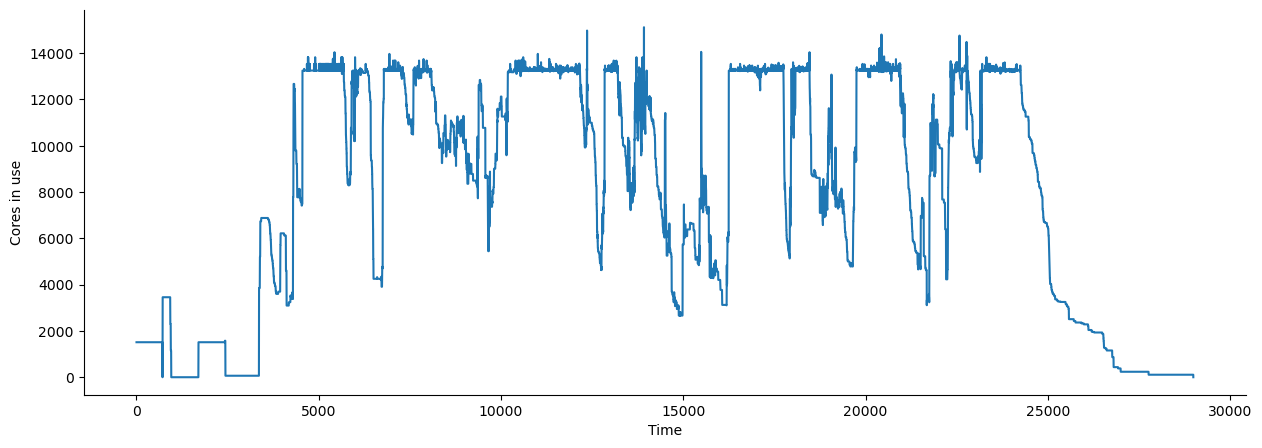

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(moldable_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("simulated_load_moldable.png")

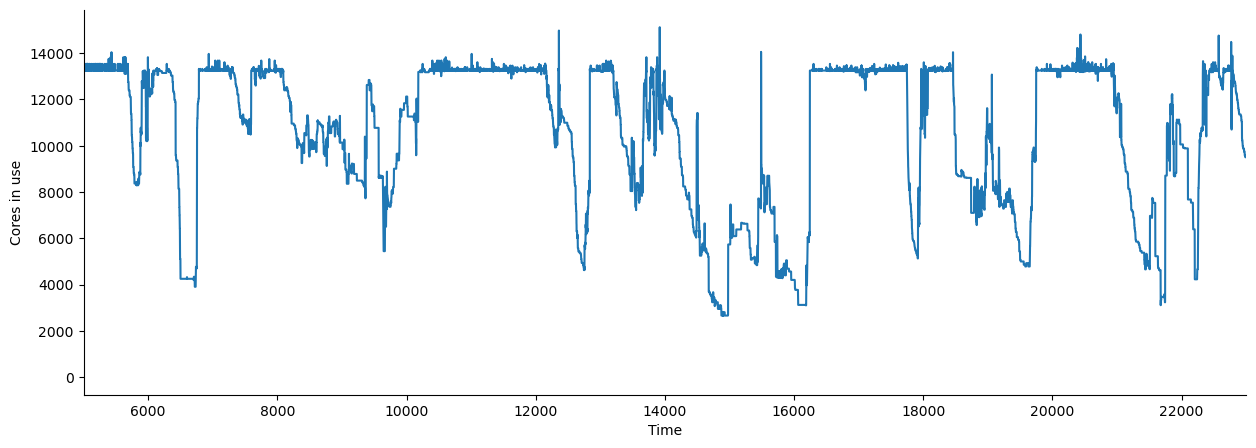

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(moldable_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
plt.xlim([5000,23000])
sns.despine()

In [52]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Moldable'
stats[type] = {}


stats[type]['nJobStart'] = sum((moldable_job_df['Start Time'] >= timeLower) & (moldable_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats[type]['nJobStart']}")

stats[type]['minLoad'] = min(moldable_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(moldable_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(moldable_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(moldable_load_a[timeLower:timeUpper+1])

usageVal = sum(moldable_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal
stats[type]['usageExcluded'] = sum(moldable_load_a[0:timeLower]) + sum(moldable_load_a[timeUpper:])
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * stats[type]['usageFraction']}")

moldable_slice_df = moldable_job_df.loc[(moldable_job_df['Start Time'] >= timeLower) & (moldable_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = moldable_slice_df['Wait Time'].min()
stats[type]['medianWait'] = moldable_slice_df['Wait Time'].median()
stats[type]['maxWait'] = moldable_slice_df['Wait Time'].max()
stats[type]['meanWait'] = moldable_slice_df['Wait Time'].mean()



print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTotJobTime'] = moldable_slice_df['Total Time'].min()
stats[type]['medianTotJobTime'] = moldable_slice_df['Total Time'].median()
stats[type]['maxTotJobTime'] = moldable_slice_df['Total Time'].max()
stats[type]['meanTotJobTime'] = moldable_slice_df['Total Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTotJobTime']}")
print(f" median = {stats[type]['medianTotJobTime']}")
print(f"    max = {stats[type]['maxTotJobTime']}")
print(f"   mean = {stats[type]['meanTotJobTime']}")



Job data:
    nJobs = 10742
Load statistics:
    min = 2664
 median = 11892
    max = 15121
   mean = 10615
 %usage = 80.1371708098497
Wait time statistics:
    min = -8.36735e-11
 median = 68.0604
    max = 988.0
   mean = 127.71315737084326
Total job time statistics:
    min = 0.4999999999199645
 median = 146.89475000000002
    max = 12615.5
   mean = 336.9944793425431


## Comparisons

In [63]:
print(f"|  Stat |   Measured | Rigid Sim. | Moldable Sim. |")
print(f"|-------|------------|------------|---------------|")

print(f"| Usage | {stats['Measured']['usageFraction']:10.4f} | {stats['Rigid']['usageFraction']:10.4f} | {stats['Moldable']['usageFraction']:10.4f} |")
print(f"| Coreh | {stats['Measured']['usageIncluded']:10.0f} | {stats['Rigid']['usageIncluded']:10.0f} | {stats['Moldable']['usageIncluded']:10.0f} |")
print(f"|  Jobs | {stats['Measured']['nJobStart']:10d} | {stats['Rigid']['nJobStart']:10d} | {stats['Moldable']['nJobStart']:10d} |")

|  Stat |   Measured | Rigid Sim. | Moldable Sim. |
|-------|------------|------------|---------------|
| Usage |     0.8060 |     0.7989 |     0.8014 |
| Coreh |  192206359 |  190516049 |  191098303 |
|  Jobs |      10749 |      10714 |      10742 |


In [64]:
# Sort dataframes by job ID so we can compare between the two simulations
rigid_sort_df = rigid_job_df.sort_values(by='JobID', ascending=True)
moldable_sort_df = moldable_job_df.sort_values(by='JobID', ascending=True)